# Working on probabilistic pairwise

In [1]:
import pandas as pd
import re
import sys 
import os
sys.path.insert(0, os.path.abspath("../"))
from pyanp.pairwise import Pairwise
import pyanp.priority as priority
from numpy import log, exp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.stats import triang,truncnorm

In [3]:
?triang

In [4]:
rv = triang(c=0.5, loc=.1, scale=10)

In [5]:
def make_log_triang(lower=1, mid=2, upper=3):
    loc = log(lower)
    scale = log(upper) - log(lower)
    c = (log(mid)-log(lower))/(log(upper)-log(lower))
    return triang(c=c, loc=loc, scale=scale)

In [6]:
tb = make_log_triang(1, 30, 100)

In [7]:
vals = tb.rvs(20)
evals = [exp(v) for v in vals]
display([evals, vals])

[[14.002717739775418,
  35.382967400675575,
  3.2614492195259674,
  4.243163288660086,
  35.44857834333355,
  2.653910709467683,
  3.8305099388330945,
  16.780634253755252,
  76.20042965879695,
  25.491559067152814,
  68.02015558745492,
  7.413541703348968,
  18.371206769752845,
  47.33744617253401,
  2.7422133839229623,
  3.3094905011704627,
  16.404797816826477,
  33.7687805128923,
  11.945395947146721,
  6.432872475286006],
 array([2.63925144, 3.56623056, 1.18217164, 1.44530905, 3.56808315,
        0.97603429, 1.34299794, 2.8202255 , 4.3333671 , 3.23834738,
        4.21980407, 2.00330829, 2.91078459, 3.85730166, 1.0087654 ,
        1.19679425, 2.79757384, 3.51953672, 2.48034593, 1.86142117])]

In [8]:
tb.mean()

2.6687891892167492

In [9]:
log(30)

3.4011973816621555

In [10]:
def make_tnorm(myclip_a, myclip_b, my_mean, my_std):
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    return truncnorm(a=a, b=b, loc=my_mean, scale=my_std)

def make_tnorm_log(my_mean, my_max):
    delta = log(my_max) - log(my_mean)
    myclip_a = log(my_mean)-delta
    myclip_b = log(my_max)
    return make_tnorm(myclip_a, myclip_b, log(my_mean), 0.5*delta)

In [11]:
tl = make_tnorm(1, 5, 3, 2)

In [12]:
tl.rvs(10)

array([2.88737527, 1.43735166, 3.50150168, 3.61561583, 1.64577454,
       2.93285268, 2.42382193, 4.63872516, 2.70691309, 2.47428528])

In [13]:
ltl = make_tnorm_log(3, 4.5)

In [14]:
[exp(v) for v in ltl.rvs(10)]

[3.715779056757969,
 3.1179341878916245,
 2.0619557024914434,
 4.464855013130548,
 2.3613394647570467,
 3.1940903722973397,
 3.7537089438664295,
 2.6898498238644764,
 3.1881056358127333,
 2.326825728288157]

## Try another idea

Let's change our vote world from 1/9 - 9 (or -9...,-2, 1,2,3,...9) into something easier to randomly work with.

Let's [-8, 8] and then if value is < 0, multiply by -1, add 1, and then invert.

Otherwise we just add 1.

We call this L-scale (for linear) and M-scale is the standard multiplication.  We need a converter

In [106]:
def ascale_mscale(val):
    if val < 0:
        val = -val
        val += 1
        val = 1.0/val
        return val
    else:
        return val+1
    
def mscale_ascale(val):
    if val == 0:
        return None
    elif val >= 1:
        return val - 1
    else:
        val = 1/val
        val = val-1
        return -val

In [107]:
ascale_mscale(-1)

0.5

In [108]:
class LScaleToMScaleDist:
    def __init__(self, distrib, name):
        self.distrib = distrib
        self.name = name
    
    def rvs(self, size=0):
        rval = self.distrib.rvs(size=size)
        for i in range(len(rval)):
            rval[i] = ascale_mscale(rval[i])
        return rval
    
    def mean(self):
        return lscale_mscale(self.distrib.mean())
    
    def __str__(self):
        return self.name

def plot_sim(rval, alt_names, idealize=False):
    if len(rval.shape) == 1:
        if idealize:
            rval = rval / max(rval)
        df = pd.DataFrame({'alts': alt_names, 'val':rval})
        return  df.plot.bar(x='alts', y='val', rot=0)
    else:
        if idealize:
            rval = (rval.transpose() / rval.max(axis=1)).transpose()
        prisdf = pd.DataFrame(data=rval, columns=alt_names)
        prismean = rval.mean(axis=0)
        print(prismean)
        meandf = pd.DataFrame({'alts':alt_names, 'val':prismean})
        fig, ax = plt.subplots()
        ax2=ax.twiny()
        meandf.plot.bar(x='alts', y='val', alpha=0.6, ax=ax2)
        prisdf.boxplot(ax=ax)
        plt.show()
    
class RPairwiseMatrix:
    def __init__(self, size):
        self.VOTES = [TRI_1, TRI_2,TRI_3, TRI_4, TRI_5, TRI_6, TRI_7, TRI_8, TRI_9]
        self.size = size
        self.matrix = np.empty([size, size], dtype=object)
        for i in range(size):
            self.matrix[i,i] = 1.0
            
    @staticmethod
    def from_lscale_nparray(arr):
        size=len(arr)
        rval = RPairwiseMatrix(size)
        for row in range(size):
            for col in range(row+1, size):
                if arr[row,col] != 0:
                    rval.set_lscale(row, col, arr[row, col])
        return rval
    
    @staticmethod
    def from_mscale_nparray(arr):
        size=len(arr)
        rval = RPairwiseMatrix(size)
        for row in range(size):
            for col in range(row+1, size):
                if arr[row,col] != 0:
                    if arr[row,col] >= 1:
                        rval.set_lscale(row, col, int(np.round(arr[row, col])-1))
                    else:
                        val = 1/arr[row,col]
                        rval.set_lscale(col, row, int(-(np.round(val)-1)))
        return rval
    
    def set_lscale(self, row, col, val):
        if isinstance(val, (int, np.int, np.int16, np.int32, np.int64)):
            if val < 0:
                tmp = row
                row = col
                col = tmp
                val = -val
            data = self.VOTES[val - 1]
            self.matrix[row,col]=data
            self.matrix[col,row] = None
        elif isinstance(val, (float, np.float, np.float16, np.float32, np.float64, np.float128)):
            if val < 0:
                tmp = row
                row = col
                col = tmp
                val = -val
            self.matrix[row, col] = triang(c=0.5, loc=(val-1.5), scale=3)
            self.matrix[col,row] = None
        else:
            raise Exception("Unknown type "+type(val))
        
    def sim(self, size=1):
        if size > 1:
            # We want a list of these things
            return [self.sim(size=1) for i in range(size)]
        rval = np.identity(self.size)
        for row in range(self.size):
            for col in range(row+1, self.size):
                data = 0
                if self.matrix[row, col] is not None:
                    data = self.matrix[row, col].rvs(size=1)[0]
                    if data >= 0:
                        data = data + 1
                    else:
                        data = 1.0/(-data+1)
                    rval[row, col] = data
                    if data != 0:
                        rval[col, row]=1.0/data
                elif self.matrix[col, row] is not None:
                    data = self.matrix[col, row].rvs(size=1)[0]
                    rval[col, row] = data
                    if data != 0:
                        rval[row, col]=1.0/data
        return rval
    
    def alt_names(self):
        return ['alt '+str(i) for i in range(1, self.size+1)]
    
    def sim_priority(self, size=1):
        mats = self.sim(size)
        if size == 1:
            rval = priority.pri_eigen(mats)
            return rval
        else:
            rval = np.array([priority.pri_eigen(mat) for mat in mats])
            return rval
                
                

        

In [109]:
TRI_1=LScaleToMScaleDist(triang(c=0.5, loc=-1, scale=2), "triangular 1")
TRI_2=LScaleToMScaleDist(triang(c=0.5, loc=-0.25, scale=2.5), "triangular 2")
TRI_3=LScaleToMScaleDist(triang(c=0.5, loc=0.5, scale=3), "triangular 3")
TRI_4=LScaleToMScaleDist(triang(c=0.5, loc=1.5, scale=3), "triangular 4")
TRI_5=LScaleToMScaleDist(triang(c=0.5, loc=2.5, scale=3), "triangular 5")
TRI_6=LScaleToMScaleDist(triang(c=0.5, loc=3.5, scale=3), "triangular 6")
TRI_7=LScaleToMScaleDist(triang(c=0.5, loc=4.5, scale=3), "triangular 7")
TRI_8=LScaleToMScaleDist(triang(c=0.5, loc=5.5, scale=3), "triangular 8")
TRI_9=LScaleToMScaleDist(triang(c=0.5, loc=6.5, scale=3), "triangular 9")

In [110]:
TRI_1.rvs(10)

array([1.64008792, 0.54506494, 0.78504424, 1.25364871, 1.15016461,
       0.88073772, 1.02072829, 1.16622579, 1.71168682, 1.66786271])

In [111]:
TRI_2.rvs(10)

array([1.96583205, 2.9531089 , 2.55153408, 2.01574672, 2.48278594,
       1.42938877, 1.24081662, 1.89575763, 2.13437602, 1.78137461])

In [112]:
pw = RPairwiseMatrix(4)

In [113]:
pw.matrix

array([[1.0, None, None, None],
       [None, 1.0, None, None],
       [None, None, 1.0, None],
       [None, None, None, 1.0]], dtype=object)

In [114]:
pw.set_lscale(0,1, 2)
pw.set_lscale(1,2, 3)
pw.set_lscale(2,3, 4)
pw.set_lscale(0, 2, 4)
pw.set_lscale(1, 3, 5)

In [115]:
pw.sim(size=5)

[array([[1.        , 2.30873307, 5.23769642, 0.        ],
        [0.43313799, 1.        , 3.218262  , 5.86119181],
        [0.19092363, 0.31072672, 1.        , 3.86249291],
        [0.        , 0.17061376, 0.25890015, 1.        ]]),
 array([[1.        , 3.52265568, 3.91695689, 0.        ],
        [0.28387674, 1.        , 3.39130767, 5.74193282],
        [0.25530023, 0.29487151, 1.        , 4.25833129],
        [0.        , 0.17415738, 0.23483377, 1.        ]]),
 array([[1.        , 2.90597803, 5.40586291, 0.        ],
        [0.34411822, 1.        , 4.3519924 , 5.40166405],
        [0.18498434, 0.22977981, 1.        , 4.67627815],
        [0.        , 0.18512814, 0.21384528, 1.        ]]),
 array([[1.        , 2.03742543, 5.1493918 , 0.        ],
        [0.49081551, 1.        , 3.53823576, 5.86282027],
        [0.19419769, 0.28262673, 1.        , 4.98151705],
        [0.        , 0.17056637, 0.20074206, 1.        ]]),
 array([[1.        , 2.31920964, 4.56854478, 0.        ],
      

In [116]:
m=pw.sim()

In [117]:
display(m)
m.max(axis=0)

array([[1.        , 2.57147899, 5.95873093, 0.        ],
       [0.38888126, 1.        , 4.67683425, 7.10616145],
       [0.16782097, 0.21381985, 1.        , 4.9357134 ],
       [0.        , 0.14072295, 0.20260496, 1.        ]])

array([1.        , 2.57147899, 5.95873093, 7.10616145])

In [118]:
pw.sim_priority()

array([0.53492717, 0.3175266 , 0.11940171, 0.02814452])

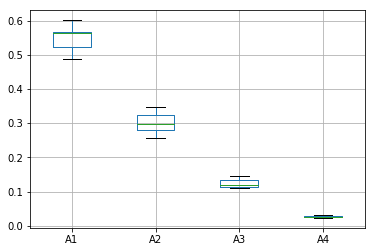

In [119]:
pris = pw.sim_priority(10)
prisdf = pd.DataFrame(data=pris, columns=["A1", "A2", "A3", "A4"])
prisdf.boxplot()

In [120]:
pw.sim_priority(1)

array([0.60241291, 0.26723692, 0.10642109, 0.02392909])

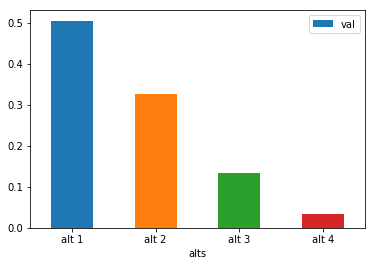

In [121]:
v=pw.sim_priority(1)
plot_sim(v, pw.alt_names())

[0.55048372 0.30256294 0.11953505 0.02741829]


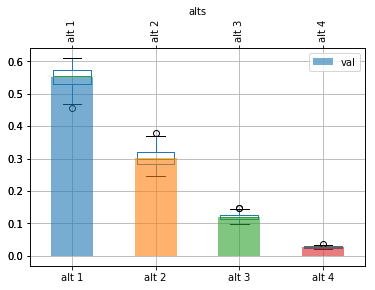

In [122]:
v=pw.sim_priority(size=200)
plot_sim(v, pw.alt_names())

[1.         0.55400268 0.21835994 0.05017552]


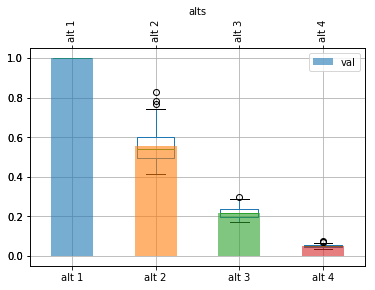

In [123]:
plot_sim(v, pw.alt_names(), idealize=True)

In [124]:
apw = np.array([
    [0, -1, 2],
    [-1., 0, 4],
    [-2, -4., 0]
], dtype=int)
arpw = RPairwiseMatrix.from_lscale_nparray(apw)
arpw.sim_priority(20)

array([[0.38238447, 0.51595579, 0.10165974],
       [0.48016281, 0.40182234, 0.11801485],
       [0.40691899, 0.47673485, 0.11634616],
       [0.40191788, 0.4651922 , 0.13288992],
       [0.43832477, 0.4192393 , 0.14243594],
       [0.42597319, 0.4313559 , 0.14267092],
       [0.34989528, 0.54882422, 0.1012805 ],
       [0.44142208, 0.45524379, 0.10333413],
       [0.34870576, 0.54615464, 0.1051396 ],
       [0.47219602, 0.41361209, 0.11419189],
       [0.407214  , 0.45175667, 0.14102932],
       [0.39808744, 0.47592705, 0.12598551],
       [0.32840135, 0.54894198, 0.12265667],
       [0.32183414, 0.55562488, 0.12254098],
       [0.46386183, 0.42894136, 0.10719682],
       [0.40473856, 0.46620738, 0.12905406],
       [0.3245833 , 0.56307959, 0.1123371 ],
       [0.45862156, 0.43855895, 0.10281949],
       [0.42046799, 0.46735842, 0.11217359],
       [0.39418194, 0.48952265, 0.11629542]])

In [125]:
mpw = np.array([
    [1, 2, 3],
    [1/2, 1, 5],
    [1/3, 1/5, 1]
])
mrpw = RPairwiseMatrix.from_mscale_nparray(mpw)

In [126]:
mrpw.sim()

array([[1.        , 1.74679192, 2.41133025],
       [0.57247803, 1.        , 5.72258369],
       [0.41470885, 0.17474624, 1.        ]])

In [127]:
mrpw.set(0,1, -6.5)

AttributeError: 'RPairwiseMatrix' object has no attribute 'set'

In [128]:
mrpw.sim_priority(20)

array([[0.54943038, 0.34946652, 0.1011031 ],
       [0.53879184, 0.35743725, 0.10377091],
       [0.52627447, 0.35520285, 0.11852268],
       [0.49306105, 0.37655851, 0.13038044],
       [0.51422197, 0.36130569, 0.12447234],
       [0.50561547, 0.37282784, 0.12155669],
       [0.52492565, 0.35004828, 0.12502608],
       [0.50465045, 0.37630463, 0.11904492],
       [0.50097954, 0.39412973, 0.10489074],
       [0.50677131, 0.3925486 , 0.10068008],
       [0.44028775, 0.42344629, 0.13626597],
       [0.5308053 , 0.35845887, 0.11073583],
       [0.5242096 , 0.3798893 , 0.0959011 ],
       [0.49692383, 0.39578553, 0.10729064],
       [0.46208478, 0.43141671, 0.10649851],
       [0.43128421, 0.42741161, 0.14130417],
       [0.47494292, 0.40175977, 0.12329731],
       [0.56634081, 0.32539266, 0.10826654],
       [0.48678102, 0.40336868, 0.10985029],
       [0.46347121, 0.41586715, 0.12066164]])

# Another idea
Here we have the pariwise comparison matrix class storing everything in LinearScale and only converting to ExponentialScale when we do the simulation

In [142]:
class RandLScalePwMatrix:
    VOTES = [
        triang(c=0.5, loc=-1, scale=2), #Triangle about 0
        triang(c=0.5, loc=-0.25, scale=2.5), #Triangle about 1
        triang(c=0.5, loc=0.5, scale=3), #Triangle about 2
        triang(c=0.5, loc=1.5, scale=3), #Triangle about 3
        triang(c=0.5, loc=2.5, scale=3), #Triangle about 4
        triang(c=0.5, loc=3.5, scale=3), #Triangle about 5
        triang(c=0.5, loc=4.5, scale=3), #Triangle about 6
        triang(c=0.5, loc=5.5, scale=3), #Triangle about 7
        triang(c=0.5, loc=6.5, scale=3), #Triangle about 8
        triang(c=0.5, loc=7.5, scale=3), #Triangle about 9
    ]
    
    def __init__(self, size):
        self.size = size
        self.matrix = np.empty([size, size], dtype=object)
        for i in range(size):
            self.matrix[i,i] = 1.0
            
    @staticmethod
    def from_nparray(arr):
        size=len(arr)
        rval = RandLScalePwMatrix(size)
        for row in range(size):
            for col in range(row+1, size):
                if arr[row,col] != 0:
                    rval.set(row, col, arr[row, col])
        return rval
    
    @staticmethod
    def from_mscale_nparray(arr):
        size=len(arr)
        rval = RandLScalePwMatrix(size)
        for row in range(size):
            for col in range(row+1, size):
                if arr[row, col]!=0:
                    rval.setm(row, col, arr[row, col])
        return rval
    
    def setm(self, row, col, multiplicative_value):
        val = mscale_ascale(multiplicative_value)
        print("mval="+str(multiplicative_value)+" addval="+str(val))
        self.set(row, col, val)
        
    def set(self, row, col, val):
        rnd_val = int(np.round(val))
        if (np.abs(rnd_val - val) < 1e-10):
            #We have essentially an integer vote
            if val < 0:
                tmp = row
                row = col
                col = tmp
                rnd_val = -rnd_val
            data = RandLScalePwMatrix.VOTES[rnd_val]
            self.matrix[row,col]=data
            self.matrix[col,row] = None
        else:
            #Floating point vote
            if val < 0:
                tmp = row
                row = col
                col = tmp
                val = -val
            self.matrix[row, col] = triang(c=0.5, loc=(val-1.5), scale=3)
            self.matrix[col,row] = None
        
    def sim(self, size=1):
        if size > 1:
            # We want a list of these things
            return [self.sim(size=1) for i in range(size)]
        rval = np.identity(self.size)
        for row in range(self.size):
            for col in range(row+1, self.size):
                data = 0
                if self.matrix[row, col] is not None:
                    data = self.matrix[row, col].rvs(size=1)[0]
                    data = ascale_mscale(data)
                    rval[row, col] = data
                    if data != 0:
                        rval[col, row]=1.0/data
                elif self.matrix[col, row] is not None:
                    data = self.matrix[col, row].rvs(size=1)[0]
                    data = ascale_mscale(data)
                    rval[col, row] = data
                    if data != 0:
                        rval[row, col]=1.0/data
        return rval
    
    def alt_names(self):
        return ['alt '+str(i) for i in range(1, self.size+1)]
    
    def sim_priority(self, size=1):
        mats = self.sim(size)
        if size == 1:
            rval = priority.pri_eigen(mats)
            return rval
        else:
            rval = np.array([priority.pri_eigen(mat) for mat in mats])
            return rval
                

In [143]:
rmls = RandLScalePwMatrix(3)

In [144]:
rmls.set(0,1, 1)
rmls.set(1,2, 2)
rmls.set(0,2, 3)

[0.99934024 0.60045912 0.22698941]


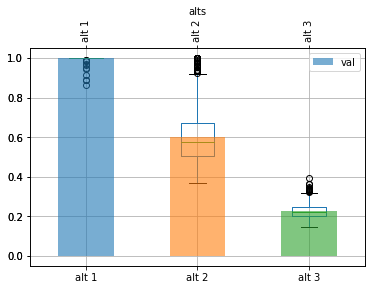

In [145]:
pris = rmls.sim_priority(1000)
plot_sim(pris, rmls.alt_names(), idealize=True)

In [149]:
r2 = RandLScalePwMatrix.from_mscale_nparray(np.array([
    [1, 2, 1/3.],
    [1/2, 1, 3],
    [3, 1/3, 1]
]))

mval=2.0 addval=1.0
mval=0.3333333333333333 addval=-2.0
mval=3.0 addval=2.0


[0.7675513  0.98033543 0.85397601]


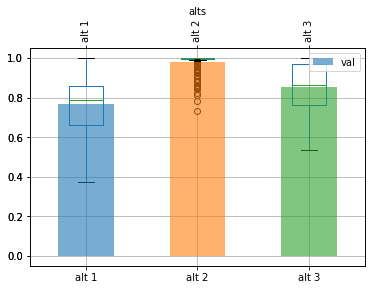

In [152]:
plot_sim(r2.sim_priority(200), r2.alt_names(), idealize=True)

In [153]:
r2.matrix[2,0].median()

2.0

In [95]:
r2.matrix

array([[1.0,
       [None, 1.0,
       [None, None, 1.0]], dtype=object)